In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math

# Imports
import math

In [2]:
# Class to hold design parameters
class cycloidal_design:
	def __init__(self, R=None, N=None, No=None, Rr=None, Ro=None, Lo=None, E=None, Re=None, maxDist=None):
		# Major parameters
		# Note that not all these parameters are used for profile generation
		self.R = R			# Rotor radius [mm]
		self.N = N			# Number of rollers [] - needs to be even for two disks
		self.No = No			# Number of output pins/holes [] - needs to be even for two disks
		self.Rr = Rr		# Roller radius [mm]
		self.Ro = Ro			# Output pin radius [mm]
		self.Lo = Lo		# Output hole midpoint location (radially) [mm]
		self.E = E		# Eccentricity [mm]
		self.Re = Re			# Input shaft radius [mm]
		
		# Parameters for point/curve generation of the cycloid disk
		self.maxDist = maxDist # Maximum allowed distance between points

	# Output hole radius [mm] - dependent computed property
	@property
	def Roh(self):
		return self.Ro + self.E
	
	# Gear ratio
	@property
	def g(self):
		return self.gear_ratio
	@property
	def gear_ratio(self):
		return 1/(self.N-1)

	# Minimum allowed distance between points
	# minDist for point generation is always half maxDist
	@property
	def minDist(self):
		return 0.5 * self.maxDist


# Get a point along the curve of the cycloidal disk
def getPoint(t, i, R, Rr, E, N):
	return getPoint_Hsieh2014(t, i, R, Rr, E, N)


def getPoint_ShinKwon2006(t, R, Rr, E, N):
	# Contact angle
	psi = math.atan2(math.sin((1-N)*t), ((R/(E*N))-math.cos((1-N)*t)))

	# Geometry of cycloidal disk as function of t
	x = (R*math.cos(t))-(Rr*math.cos(t+psi))-(E*math.cos(N*t))
	y = (-R*math.sin(t))+(Rr*math.sin(t+psi))+(E*math.sin(N*t))
	return (x,y)


# Hsieh, 2014
def getPoint_Hsieh2014(t, i, R, Rr, E, N):
	# Parameters
	c = E		# Eccentricity
	rho = Rr	# Roller radius
	E = R		# Distance to roller center

	# Variables
	phi_2 = t
	phi_1 = phi_2 * (N-1)/N

	# Pin number
	zeta_i = 2*math.pi*(i-1)/N

	# Solution to meshing equation (Eq. 7)
	alpha = math.atan2(math.sin(phi_1 - zeta_i), (E/(c*N))-math.cos(phi_1 - zeta_i))

	# Outer rotor (cycloidal disk) according to Hsieh, 2014 (Eq. 4)
	x = E * math.sin(zeta_i - phi_1 + phi_2) + \
		rho * math.sin(alpha + phi_1 - phi_2 - zeta_i) - \
		c * math.sin(phi_2)
	y = E * math.cos(zeta_i - phi_1 + phi_2) - \
		rho * math.cos(alpha + phi_1 - phi_2 - zeta_i) - \
		c * math.cos(phi_2)

	return (x,y)


# Get a point along the outer profile
def getPoint_outer(t, i, R, Rr, E, N, psi_1_prev):
	return getPoint_outer_Hsieh2014(t, i, R, Rr, E, N, psi_1_prev)


# Hsieh, 2014
def getPoint_outer_Hsieh2014(t, i, R, Rr, E, N, psi_1_prev):
	# Parameters
	c = E		# Eccentricity
	rho = Rr	# Roller radius
	E = R		# Distance to roller center

	# Variables
	phi_2 = t
	phi_1 = phi_2 * (N-1)/N

	# Pin number
	zeta_i = 2*math.pi*(i-1)/N

	# Solution to meshing equation (Eq. 7)
	alpha = math.atan2(math.sin(phi_1 - zeta_i), (E/(c*N))-math.cos(phi_1 - zeta_i))

	# Define shorthands
	a = E / (c*N)
	b = math.sin(zeta_i - phi_1)
	cc = zeta_i - phi_1 + phi_2
	d = rho / (c*N)
	e = math.sin(alpha - zeta_i + phi_1)
	f = alpha
	g = phi_2

	# More shorthands in A*sin + B*cos = C
	A = a * math.cos(cc) - d * math.cos(cc-f) - math.cos(g)
	B = -a * math.sin(cc) + d * math.sin(cc-f) + math.sin(g)
	C = a * b + d * e

	# Solution to the second meshing equation (Eq. 11)
	psi_1 = 2 * math.atan2(A + math.sqrt(A**2 + B**2 - C**2), B + C)

	# Take out multiples of pi
	# If water is wet...
	if 1==1 or abs(psi_1 - psi_1_prev) > 0.1:
		diff = psi_1 - psi_1_prev
		multiples = round(diff / math.pi) * math.pi
		psi_1 = psi_1 - multiples

	if abs(psi_1 - psi_1_prev) > 0.1:
		print('Warning: t =', round(t,3), ', psi_1 =', round(psi_1,3), ', remaining difference with previous is still', round(psi_1 - psi_1_prev,3), 'and I removed', round(multiples,3))

	# Define psi_2
	psi_2 = ((N-1)/N) * psi_1

	# Outer rotor according to Hsieh, 2014 (Eq. 8)
	x = E * math.sin(zeta_i - phi_1 + phi_2 - psi_1 + psi_2) + \
		rho * math.sin(alpha + phi_1 - phi_2 + psi_1 - psi_2 - zeta_i) - \
		c * (math.sin(psi_2) - math.sin(psi_1 - psi_2 - phi_2))
	y = E * math.cos(zeta_i - phi_1 + phi_2 - psi_1 + psi_2) - \
		rho * math.cos(alpha + phi_1 - phi_2 + psi_1 - psi_2 - zeta_i) - \
		c * (math.cos(psi_2) + math.cos(psi_1 - psi_2 - phi_2))

	return (x,y,psi_1)


# Get the Euclidian distance between two points
def getDist(xa, ya, xb, yb):
	return math.sqrt((xa-xb)**2 + (ya-yb)**2)


# Print out design info
def design_info(design):
	# Get design parameters
	# Major parameters
	R = design.R	# Rotor radius [mm]
	N = design.N	# Number of rollers [] - needs to be even for two disks
	No = design.No	# Number of output pins/holes [] - needs to be even for two disks
	Rr = design.Rr	# Roller radius [mm]
	Ro = design.Ro	# Output pin radius [mm]
	Lo = design.Lo	# Output hole midpoint location (radially) [mm]
	E = design.E	# Eccentricity [mm]
	Re = design.Re	# Input shaft radius [mm]
	
	# Dependent parameters
	Roh = design.Roh # Output hole radius [mm]
	
	# Parameters for point/curve generation of the cycloid disk
	maxDist = design.maxDist	# Maximum allowed distance between points
	minDist = design.minDist	# Minimum allowed distance between points		
	
	# Compute gear ratio
	g = 1/(N-1)

	# Output major parameters
	print('Rotor radius R =', R, 'mm')
	print('Number of rollers N =', N)
	print('Ratio will be 1/(N-1) = g =', g)
	
	# Check wall thicknesses
	print('Minimum wall thicknesses:')
	
	# Input shaft to output hole
	x_input_right_edge = E + Re
	x_output_left_edge = E + Lo - Roh
	d = x_output_left_edge-x_input_right_edge
	print('    Input shaft to output hole:', round(d,3), 'mm.')
	
	# Output hole to disk edge
	x_output_edge = E + Lo + Roh
	x_disk_edge = E + (R-Rr) # TODO CHECK
	d = x_disk_edge-x_output_edge
	print('    Output hole to disk edge:', round(d,3), 'mm.')
	
	# Output hole to output hole
	x1 = Lo * math.cos(1 * 2 * math.pi / No) + E
	y1 = Lo * math.sin(1 * 2 * math.pi / No)
	x2 = Lo * math.cos(2 * 2 * math.pi / No) + E
	y2 = Lo * math.sin(2 * 2 * math.pi / No)
	d = getDist(x1, y1, x2, y2) - 2 * Roh
	print('    Output hole to output hole:', round(d,3), 'mm.')


# Generate cycloidal disk
def generate_disk(design, debug=False):
	# Get design parameters
	# Major parameters
	R = design.R	# Rotor radius [mm]
	N = design.N	# Number of rollers [] - needs to be even for two disks
	No = design.No	# Number of output pins/holes [] - needs to be even for two disks
	Rr = design.Rr	# Roller radius [mm]
	Ro = design.Ro	# Output pin radius [mm]
	Lo = design.Lo	# Output hole midpoint location (radially) [mm]
	E = design.E	# Eccentricity [mm]
	Re = design.Re	# Input shaft radius [mm]
	
	# Dependent parameters
	Roh = design.Roh # Output hole radius [mm]
	
	# Parameters for point/curve generation of the cycloid disk
	maxDist = design.maxDist	# Maximum allowed distance between points
	minDist = design.minDist	# Minimum allowed distance between points	
	
	# Prepare list of points
	points = []
	
	# Get starting point
	(xs, ys) = getPoint(0, 1, R, Rr, E, N)
	points.append((xs,ys))
	#print('(xs, ys) = (', xs, ', ', ys, ')')
	(x, y) = (xs, ys)
	
	# Compute ending point
	et = 2 * math.pi # Angular offset ending point
	
	# Initialise point generation
	dist = 0 # Distance to previous point
	dt = 2*math.pi / N / 100 # Initial step size
	numPoints = 0
	
	# Generate cycloidal disk
	# For each roller pin..
	for i in range(1, N+1):
		if debug:
			print('----')
			print('i =', i)
	
		# Starting angle
		t = 0

		# Flag to make sure we generate a point *at* et (=2pi) each time
		lastPoint = False
	
		# While we have not reached the starting point...
		while (i < N or getDist(xs, ys, x, y) > maxDist):
			if debug:
				print('----')
				print('t =', round(t,4), ', dt =', dt)

			# If our current increment brings us beyond the end point,
			# we generate one more point and end for this value of i.
			if t+dt >= et:
				dt = et - t
				lastPoint = True
				if debug:
					print('Instead generating last point at ', t+dt, 'using dt = ', dt)

			# Get a new point with the existing stepsize
			(xt, yt) = getPoint(t+dt, i, R, Rr, E, N)
	
			# Compute the distance to the previous point
			dist = getDist(x, y, xt, yt)

			if debug:
				print('initial try before adjustment: dist =', dist, 'for point at', (xt, yt))
	
			# Set angle increment adjustment
			ddt = dt/2
			lastTooBig = False
			lastTooSmall = False
	
			# Find a good stepsize dt that puts the new point within a certain distance range
			# If it's the last point, we don't care about minimum distance
			while (not lastPoint and dist < minDist) or dist > maxDist:
				if dist > maxDist:
					# If we're too far away, decrease the stepsize

					# If we went from too small to too big, decrease the size of changes ddt
					if (lastTooSmall):
						ddt /= 2
		
					lastTooSmall = False
					lastTooBig = True
	
					# Don't decrease by more than half
					if (ddt > dt/2):
						ddt = dt/2
	
					dt -= ddt

					if debug:
						print('Decreasing stepsize to', dt)
	
				elif dist < minDist:
					# If we're too close, increase the stepsize

					# If we went from too big to too small, decrease the size of changes ddt
					if (lastTooBig):
						ddt /= 2

					lastTooSmall = True
					lastTooBig = False
					dt += ddt

					# Don't step over the end
					if t+dt >= et:
						dt = et - t
						lastPoint = True
						if debug:
							print('Instead generating last point at ', t+dt, 'using dt = ', dt)
					elif debug:
						print('Increasing stepsize to', dt)

				# Raise an exception if the stepsize diverges or converges to zero
				if dt > 1.0:
					raise Exception('Stepsize diverging! Stopping.')
				if dt <= 1e-15:
					raise Exception('Stepsize converging to zero! Stopping.')

				# With this new dt, compute another point and get its distance from previous
				(xt, yt) = getPoint(t+dt, i, R, Rr, E, N)
				dist = getDist(x, y, xt, yt)

				if debug:
					print('dist =', dist, 'for point at', (xt, yt))
	
			# Increment the angular offset by the angle increment with which the new point was computed
			t += dt

			# Store found point
			if debug:
				print('Adding point at', (xt, yt))
			(x, y) = (xt, yt)
			points.append((x,y))
			numPoints += 1

			if debug:
				print('t is now', t)

			# If the stepsize was reduced because we were too far,
			# We generate one more point
			#if t < et:
				#lastPoint = False

			if lastPoint:
				if debug:
					print('This was the last point, carrying on...')
				break
	
	# Add starting point again as last point to perfectly close the path
	points.append((xs,ys))
	
	return (points, numPoints)


# Generate cycloidal outer profile
def generate_outer_profile(design, debug=False):
	# Get design parameters
	# Major parameters
	R = design.R	# Rotor radius [mm]
	N = design.N	# Number of rollers [] - needs to be even for two disks
	No = design.No	# Number of output pins/holes [] - needs to be even for two disks
	Rr = design.Rr	# Roller radius [mm]
	Ro = design.Ro	# Output pin radius [mm]
	Lo = design.Lo	# Output hole midpoint location (radially) [mm]
	E = design.E	# Eccentricity [mm]
	Re = design.Re	# Input shaft radius [mm]
	
	# Dependent parameters
	Roh = design.Roh # Output hole radius [mm]
	
	# Parameters for point/curve generation of the cycloid disk
	maxDist = design.maxDist	# Maximum allowed distance between points
	minDist = design.minDist	# Minimum allowed distance between points	
	
	# Prepare list of points
	points_outer = []
	psi_1_list = []
	
	# Outer profile - get starting point
	(xs_outer, ys_outer, psi_1_prev) = getPoint_outer(0, 1, R, Rr, E, N, math.pi)
	# points_outer.append((xs_outer,ys_outer))
	#print('(xs_outer, ys_outer) = (', xs_outer, ', ', ys_outer, ')')
	(x_outer, y_outer) = (xs_outer, ys_outer)
	
	# Compute ending point
	et = 2 * math.pi # Angular offset ending point
	
	# Initialise point generation
	dist = 0 # Distance to previous point
	dt = 2*math.pi / N / 100 # Initial step size
	numPoints_outer = 0
	
	# Generate outer profile
	# While we haven't reached the starting point again...
	# Also don't continue too for long (something went wrong in that case)
	i=1
	while (i < N or getDist(xs_outer, ys_outer, x_outer, y_outer) > maxDist) and i<(N+3):
		if debug:
			print('----')
			print('i =', i)

		# Starting angle
		t = 0 # TODO issues for t=0; programmatically avoid it?

		# Flag to make sure we generate a point *at* et (=2pi) each time
		lastPoint = False

		# While we have not reached the starting point...
		while (i < N or getDist(xs_outer, ys_outer, x_outer, y_outer) > maxDist):
			if debug:
				print('----')
				print('t =', round(t,4), ', dt =', dt)

			# If our current increment brings us beyond the end point,
			# we generate one more point and end for this value of i.
			if t+dt >= et:
				dt = et - t
				lastPoint = True
				if debug:
					print('Instead generating last point at ', t+dt, 'using dt = ', dt)

			# Get a new outer point with the existing stepsize
			(xt, yt, psi_1_prev_temp) = getPoint_outer(t+dt, i, R, Rr, E, N, psi_1_prev)

			# Compute the distance to the previous point
			dist = getDist(x_outer, y_outer, xt, yt)

			if debug:
				print('initial try before adjustment: dist =', dist, 'for point at', (xt, yt))

			# Set angle increment adjustment
			ddt = dt/2
			lastTooBig = False
			lastTooSmall = False

			# Find a good stepsize dt that puts the new point within a certain distance range
			# If it's the last point, we don't care about minimum distance
			while (not lastPoint and dist < minDist) or dist > maxDist:
				#print('Trying dt =', dt)
				if dist > maxDist:
					# If we're too far away, decrease the stepsize

					# If we went from too small to too big, decrease the size of changes ddt
					if (lastTooSmall):
						ddt /= 2
		
					lastTooSmall = False
					lastTooBig = True

					# Don't decrease by more than half
					if (ddt > dt/2):
						ddt = dt/2

					dt -= ddt

					if debug:
						print('Decreasing stepsize to', dt)

				elif dist < minDist:
					# If we're too close, increase the stepsize

					# If we went from too big to too small, decrease the size of changes ddt
					if (lastTooBig):
						ddt /= 2

					lastTooSmall = True
					lastTooBig = False
					dt += ddt

					# Don't step over the end
					if t+dt >= et:
						dt = et - t
						lastPoint = True
						if debug:
							print('Instead generating last point at ', t+dt, 'using dt = ', dt)
					elif debug:
						print('Increasing stepsize to', dt)

				# Raise an exception if the stepsize diverges or converges to zero
				if dt > 1.0:
					raise Exception('Stepsize diverging! Stopping.')
				if dt <= 1e-15:
					raise Exception('Stepsize converging to zero! Stopping.')

				# With this new dt, compute another point and get its distance from previous
				(xt, yt, psi_1_prev_temp) = getPoint_outer(t+dt, i, R, Rr, E, N, psi_1_prev)
				dist = getDist(x_outer, y_outer, xt, yt)

				if debug:
					print('dist =', dist, 'for point at', (xt, yt))

			if debug:
				print('Finally used: t =', t, ', dt =', dt, ' and t+dt =', t+dt)

			# Increment the angular offset by the angle increment with which the new point was computed
			t += dt

			# Store found point
			if debug:
				print('Adding point at', (xt, yt))
			(x_outer, y_outer) = (xt, yt)
			points_outer.append((x_outer,y_outer))
			psi_1_prev = psi_1_prev_temp
			psi_1_list.append(psi_1_prev)
			numPoints_outer += 1

			if debug:
				print('t is now', t)

			# If the stepsize was reduced because we were too far,
			# We generate one more point
			#if t < et:
				#lastPoint = False

			if lastPoint:
				if debug:
					print('This was the last point, carrying on...')
				break

		# Increment pin counter
		i += 1

	# Add starting point again as last point to perfectly close the path
	# points_outer.append((xs_outer,ys_outer))
	
	return (points_outer, numPoints_outer, psi_1_list)


In [3]:

# Rotate a vector consisting of a tuple
def rotate(v, theta):
	if type(v) is np.ndarray:
		for i,vi in enumerate(v):
			(x,y) = rotate((vi[0],vi[1]),theta)
			v[i][0] = x
			v[i][1] = y

		return v
	else:
		# Get x/y coordinates of point
		x = v[0]
		y = v[1]

		# Return new tuple
		return (	x * np.cos(theta) - y * np.sin(theta),
					x * np.sin(theta) + y * np.cos(theta)		)


# Move points by a vector m
def move(v, m):
	if type(v) is np.ndarray:
		v = v+np.array(m)
		return v
	else:
		return (v[0]+m[0], v[1]+m[1])

In [4]:
#generate disk
# Move points by a vector m
d = cycloidal_design()
d.R = 34			# Rotor radius [mm]
d.N = 14			# Number of rollers [] - needs to be even for two disks
d.Rr = 3.5			# Roller radius [mm]
d.E =  1.5  		# Eccentricity [mm]

d.Ro = 6.5/2			# Output pin radius [mm]
d.Lo = d.R*0.6		# Output hole midpoint location (radially) [mm]
d.No = 6			# Number of output pins/holes [] - needs to be even for two disks
d.Re = 10			# Input shaft radius [mm]
	
# Parameters for point/curve generation of the cycloid disk
d.maxDist = 0.01   # Maximum allowed distance between points

design_info(d)

print('Generating cycloidal disk...')
(points, numPoints) = generate_disk(d, debug=False)
points = np.array(points)

print('Generating outer profile...')
(points_outer, numPoints_outer, psi_1_list) = generate_outer_profile(d, debug=False)
points_outer = np.array(points_outer)
psi_1_list = np.array(psi_1_list)



Rotor radius R = 34 mm
Number of rollers N = 14
Ratio will be 1/(N-1) = g = 0.07692307692307693
Minimum wall thicknesses:
    Input shaft to output hole: 5.65 mm.
    Output hole to disk edge: 5.35 mm.
    Output hole to output hole: 10.9 mm.
Generating cycloidal disk...
Generating outer profile...


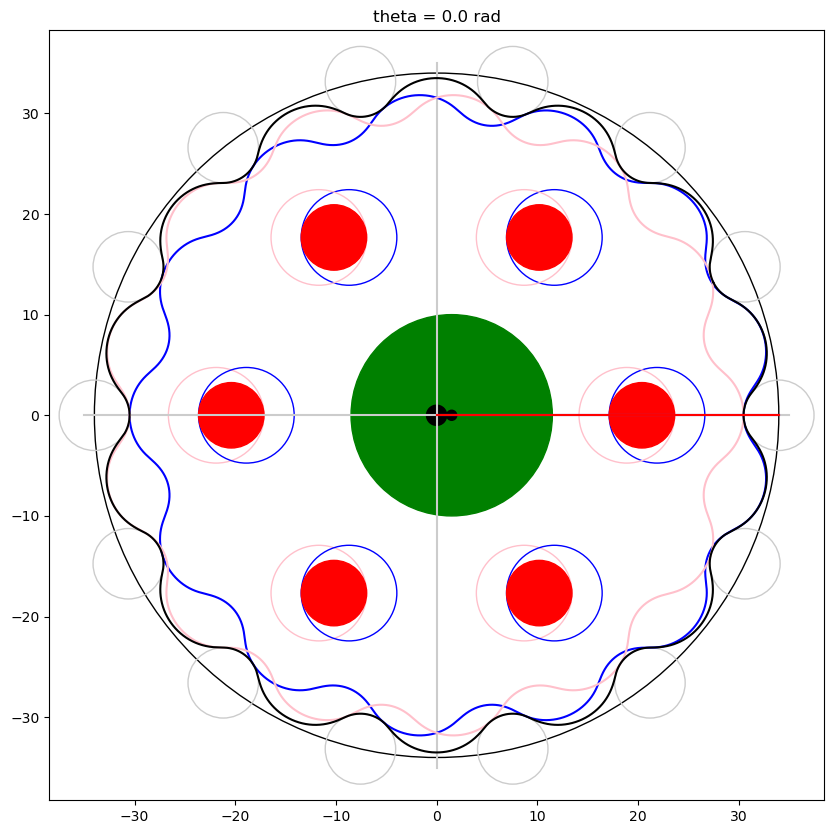

In [5]:
# Get design parameters for plotting
# Major parameters
R = d.R	# Rotor radius [mm]
N = d.N	# Number of rollers [] - needs to be even for two disks
No = d.No	# Number of output pins/holes [] - needs to be even for two disks
Rr = d.Rr	# Roller radius [mm]
Ro = d.Ro	# Output pin radius [mm]
Lo = d.Lo	# Output hole midpoint location (radially) [mm]
E = d.E	# Eccentricity [mm]
Re = d.Re	# Input shaft radius [mm]

# Dependent parameters
Roh = d.Roh # Output hole radius [mm]
g = d.g	# Gear ratio

twoDisks = True

theta_end = 2*np.pi # One input rotation
n = 1 # Number of frames in total

# For a range of thetas..
for theta in np.linspace(0, theta_end, n):
	# Figure and axes
	fig = plt.figure(figsize=(10,10))
	ax = plt.axes()

	# x=0 and y=0 grid lines
	ax.plot((-R-1,R+1),(0,0), color=(0.8,0.8,0.8))
	ax.plot((0,0),(-R-1,R+1), color=(0.8,0.8,0.8))

	# Rotor radius
	c = plt.Circle((0,0), R, fill=False)
	ax.add_artist(c)

	# Input shaft and axis of rotation
	c = plt.Circle(rotate((E,0),theta), Re, color='g')
	ax.add_artist(c)
	c = plt.Circle(rotate((E,0),theta), 0.5, color='k')
	ax.add_artist(c)
	c = plt.Circle((0,0), 1.0, color='k')
	ax.add_artist(c)

	# Show a line depicting the input axis
	p = rotate((R,0),theta)
	ax.plot((0,p[0]), (0,p[1]), color='b')

	# Plot of rotor curve

	# Get numpy array of points
	dt=np.dtype('float,float')
	points_arr = np.array(points)
	points_arr2 = points_arr.copy()

	# Transform in three steps:
	# 1. Rotate around rollers
	# 2. Offset by eccentricity
	# 3. Rotate with input shaft
	points_arr = rotate(points_arr, -N*g*theta) # Guessed this angle heuristically but it works
	points_arr = rotate(points_arr, -math.pi/2) # Hsieh, 2014.
	points_arr = move(points_arr, (E,0)) # Hsieh, 2014.
	points_arr = rotate(points_arr, theta)
	ax.plot(points_arr[:,0], points_arr[:,1], color='b')

	# Compute rotational offset for second disk and its holes
	# This doesn't seem to be necessary
	offset = 0

	# Plot a second disk
	if twoDisks:
		points_arr2 = rotate(points_arr2, -N*g*theta+offset)
		points_arr2 = rotate(points_arr2, -math.pi/2)
		points_arr2 = move(points_arr2, (E,0))
		points_arr2 = rotate(points_arr2, theta+math.pi)
		ax.plot(points_arr2[:,0], points_arr2[:,1], color='pink')

	# Plot the outer curve
	points_outer_arr = np.array(points_outer)
	points_outer_arr = rotate(points_outer_arr, -math.pi/2 + math.pi/N) # To align with our original pins
	ax.plot(points_outer_arr[:,0], points_outer_arr[:,1], color='k')

	# Add rollers using circles
	for i in range(0,N):
		x = R * math.cos(i * 2 * math.pi / N)
		y = R * math.sin(i * 2 * math.pi / N)
		c = plt.Circle((x,y), Rr, color=(0.8,0.8,0.8), fill=False)
		ax.add_artist(c)

	# Add output holes on rotor
	for i in range(0,No):
		# Get locations of output holes on disk
		x = Lo * math.cos(i * 2 * math.pi / No)
		y = Lo * math.sin(i * 2 * math.pi / No)

		# Same three transform steps as above
		p = rotate((x,y), -N*g*theta)
		p = move(p, (E,0))
		p = rotate(p, theta)

		# Plot
		c = plt.Circle(p, Roh, color='b', fill=False)
		ax.add_artist(c)

		# If we are plotting two disks..
		if twoDisks:
			# Same procedure for second disk holes
			p = rotate((x,y), -N*g*theta+offset)
			p = move(p, (E,0))
			p = rotate(p, theta+math.pi)

			# Plot
			c = plt.Circle(p, Roh, color='pink', fill=False)
			ax.add_artist(c)

	# Add output pins
	for i in range(0,No):
		x = Lo * math.cos(i * 2 * math.pi / No)
		y = Lo * math.sin(i * 2 * math.pi / No)
		c = plt.Circle(rotate((x,y),-theta*g), Ro, color='r')
		ax.add_artist(c)

	# Show output axis line
	p = rotate((R,0),-theta*g)
	ax.plot((0,p[0]), (0,p[1]), color='r')

	ax.set_title('theta = ' + str(round(theta,2)) + ' rad')

ax.axis('equal')
plt.show()


generated profiles. disk has 32264 points, outer profile has 34131 points


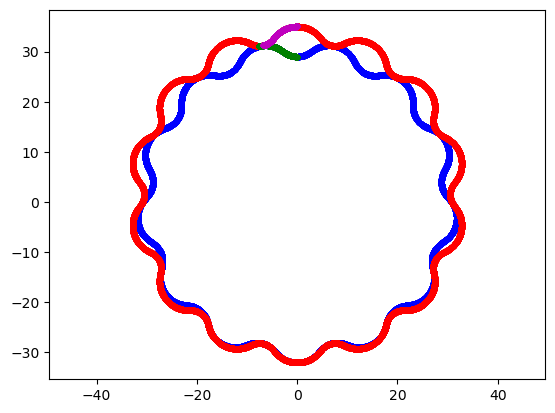

In [8]:
top_angle = math.pi/2

# select only single lobe of disk profile
point_angle = np.arctan2(points[:,1], points[:,0])
half_disk_lobe = points[np.logical_and(point_angle > top_angle, point_angle < top_angle+(math.pi/(d.N-1)))]

#ensure exact matches of end-points:
half_disk_lobe[-1, :] = [0, d.R-d.E-d.Rr]
half_disk_lobe[0, :] = rotate([0, d.R-d.Rr+d.E], np.pi/(d.N-1))


# xy point to polar coordinate angle
point_angle = np.arctan2(points_outer[:,1], points_outer[:,0])
half_pinwheel_lobe = points_outer[np.logical_and(point_angle > top_angle, point_angle < top_angle+(math.pi/d.N))]

#ensure exact matches of end-points:
half_pinwheel_lobe[-1, :] = [0, d.R-d.Rr+2*d.E]
half_pinwheel_lobe[0, :] = rotate([0, d.R-d.Rr], np.pi/d.N)


print(f'generated profiles. disk has {numPoints} points, outer profile has {numPoints_outer} points')

plt.figure()
plt.plot([x for (x,y) in points], [y for (x,y) in points], 'b.-', label='Cycloidal disk')	
plt.plot([x for (x,y) in points_outer], [y+d.E for (x,y) in points_outer], 'r.-', label='Outer profile')
plt.plot([x for (x,y) in half_disk_lobe], [y for (x,y) in half_disk_lobe], 'g.-', label='Cycloidal disk lobe')
plt.plot([x for (x,y) in half_pinwheel_lobe], [y+d.E for (x,y) in half_pinwheel_lobe], 'm.-', label='Outer profile lobe')
plt.axis('equal')

# #zoom in
# plt.xlim(-d.R/8, d.R/8)
# plt.ylim(d.R*0.7, d.R*1.2)

plt.show()

In [7]:
# save plots to dxf
import ezdxf
from ezdxf.entities import Spline

doc = ezdxf.new('R2010')
msp = doc.modelspace()

# draw the disk lobe segment
doc.layers.add(name='Cycoidal Disk', color=1)
spline = msp.add_spline(half_disk_lobe, dxfattribs={'layer': 'Cycoidal Disk'})
msp.add_line(half_disk_lobe[-1], [0, 0], dxfattribs={'layer': 'Cycoidal Disk'})
msp.add_line(half_disk_lobe[0], [0, 0], dxfattribs={'layer': 'Cycoidal Disk'})

# draw the pinwheel lobe segment
doc.layers.add(name='Non-Pinwheel', color=2)
eccentric_offset = np.array([0, d.E])
spline = msp.add_spline(half_pinwheel_lobe+eccentric_offset, dxfattribs={'layer': 'Non-Pinwheel'})
msp.add_line(half_pinwheel_lobe[-1]+eccentric_offset, [0, d.R+d.E], dxfattribs={'layer': 'Non-Pinwheel'})
msp.add_line(half_pinwheel_lobe[0]+eccentric_offset, rotate([0, d.R], math.pi/d.N)+eccentric_offset, dxfattribs={'layer': 'Non-Pinwheel'})
msp.add_arc([0, d.E], d.R, 90, 90+(180/d.N), dxfattribs={'layer': 'Non-Pinwheel'})

filename = f"cycloid_N{d.N}_R{d.R}_Rr{d.Rr}_E{d.E}.dxf"
print(f"saved profiles to {filename}")
doc.saveas(filename)


saved profiles to cycloid_N14_R34_Rr3.5_E1.5.dxf
